# Exploratory Data Analysis of Credit Risk Datasets and Feature Engineering
This dataset is made up of three tables. In this dataset, we do a bit of data exploration and feature engineering

In [1]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt

### Utility Functions

In [2]:
# Utility Functions
# ==================

# Check if data has missing values
def check_missing(df: pd.DataFrame):
    missing = {c: df[c].hasnans for c in df.columns}
    for k, v in missing.items():
        if v:
            mv = df[k].isna().sum()
            print(f'{k} has {mv} missing values')

# Plot
def count_duplicates(df: pd.DataFrame, col: str):
    full_length = len(df.index)
    col_unique = df[col].nunique()
    if col_unique == full_length:
        print('There are no duplicates')
        return None
    return full_length - col_unique

### Load Datasets

In [3]:
data = open('bank.xlsx', 'rb')
person: pd.DataFrame = pd.read_excel(data, sheet_name='person data')
loan: pd.DataFrame = pd.read_excel(data, sheet_name='loan data')
transaction: pd.DataFrame = pd.read_excel(data, sheet_name='transaction data')

# Save memory by deleting data object since it's no longer needed
del data

## People

In [4]:
person.sample(5)

,Person_ID,Loan Account Number,Relationship_Start_Date,OCCUPATION,DATE_OF_BIRTH,BUSINESS_TYPE,STATE,No_of_Mobile_No,CUSTOMER_EMAIL,GENDER,MARITAL_STATUS,REGION,BASIC_CURRENT,BASIC_SAVINGS,ATMCARD,TOTAL_PRODUCTS
674,2286699,757Z700193330004,2004-04-30,1,1970-08-07,1,LAGOS,1,N,M,Single,LAGOS_MAINLAND,N,N,Y,5
2464,7851952,414Z700193360501,2018-07-03,1,1983-12-27,1,Ebonyi,1,N,M,Married,LAGOS_ISLAND,N,N,Y,1
1111,7685053,794Z700193290003,2018-05-11,Artisan,1978-02-23,Artisan,Benue,1,N,M,Married,ABUJA,N,N,Y,1
2533,5533114,678Z700193030001,2013-10-29,Domestic trade retail,1979-01-01,OTHERS,LAGOS,1,N,F,0,LAGOS_MAINLAND,N,N,N,1
979,5985994,803Z700192810001,2015-06-22,NaN,1985-06-22,NaN,Imo,1,N,M,Single,SOUTH,Y,N,Y,3


In [5]:
person.describe()

,Person_ID,No_of_Mobile_No,TOTAL_PRODUCTS
count,2.593000e+03,2593.000000,2593.000000
mean,6.197481e+06,1.069418,1.743540
std,2.128658e+06,0.254212,2.480826
min,8.280100e+04,1.000000,0.000000
25%,4.875614e+06,1.000000,0.000000
50%,6.469022e+06,1.000000,1.000000
75%,8.056388e+06,1.000000,2.000000
max,8.977774e+06,2.000000,45.000000


In [6]:
check_missing(person)

OCCUPATION has 818 missing values
BUSINESS_TYPE has 1278 missing values


<AxesSubplot:xlabel='STATE'>

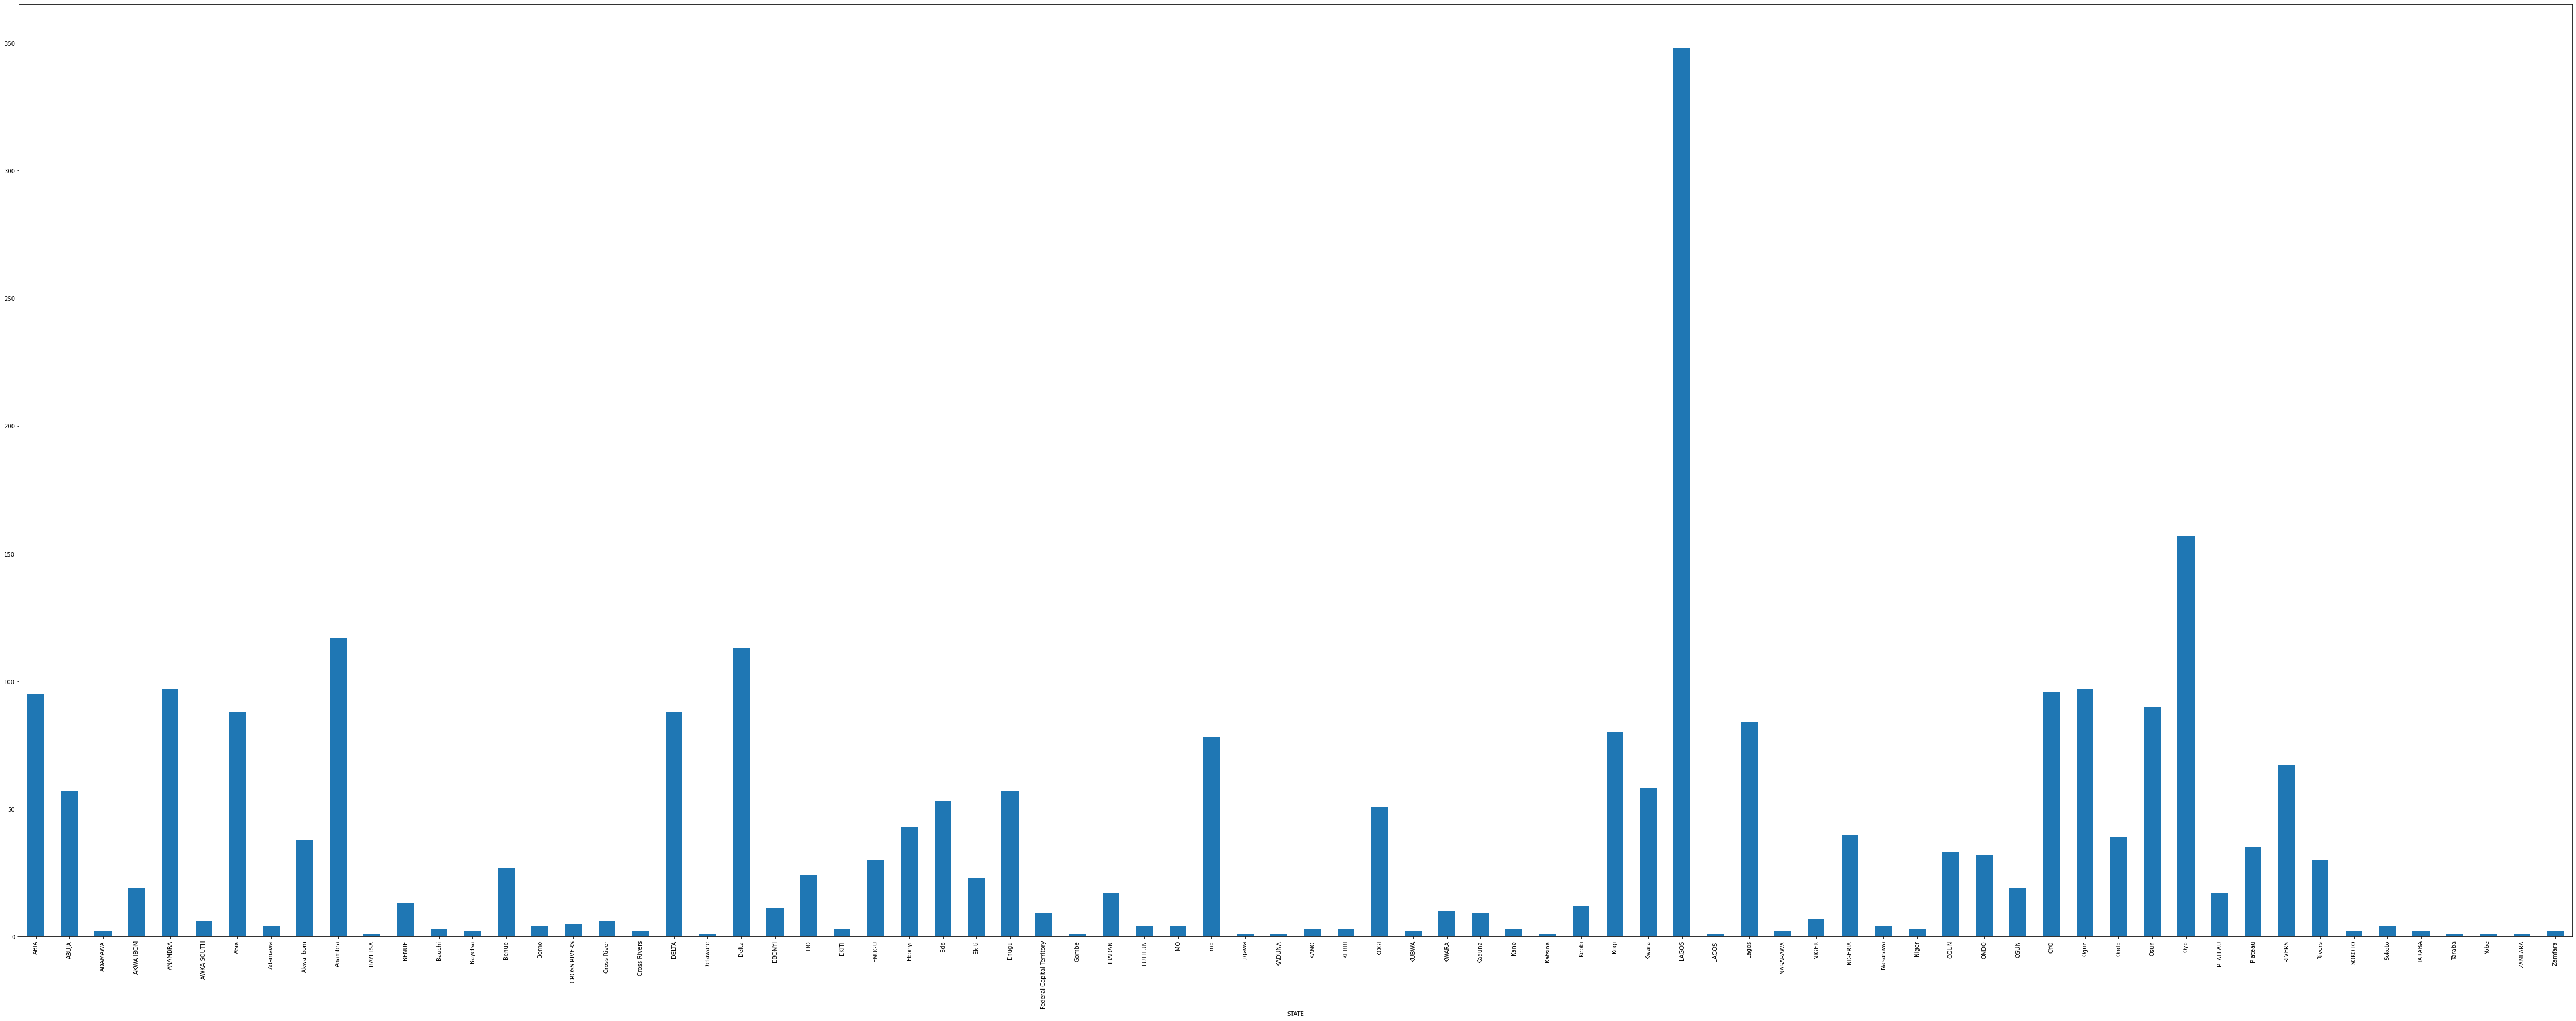

In [7]:
fig, ax = plt.subplots(figsize=(80, 30))
person.groupby(by=['STATE']).count()['Person_ID'].plot.bar(ax=ax)

In [8]:
state_counts = person.groupby(by=['STATE']).count()['Person_ID']
max_state = state_counts.idxmax()
_max = state_counts.max()
min_state = state_counts.idxmin()
_min = state_counts.min()
print(f'{max_state} has the largest number of applications ({_max}) and {min_state} has the lowest number of applications ({_min}).\n')

status_counts = person.groupby(by=['MARITAL_STATUS']).count()['Person_ID'].to_dict()
for k, v in status_counts.items():
    print(f'{v} {k} people applied for loans.')
print('\n')

LAGOS has the largest number of applications (348) and BAYELSA has the lowest number of applications (1).

558 0 people applied for loans.
44 Divorced people applied for loans.
1333 Married people applied for loans.
1 Seperated people applied for loans.
655 Single people applied for loans.
2 Spouse_Expired people applied for loans.




In [9]:
num_current = person[person['BASIC_CURRENT'] == 'Y'].count()['Person_ID']
num_saving = person[person['BASIC_SAVINGS'] == 'Y'].count()['Person_ID']
num_both = person[(person['BASIC_CURRENT'] == 'Y') & (person['BASIC_SAVINGS'] == 'Y')].count()['Person_ID']
num_neither = person[(person['BASIC_CURRENT'] == 'N') & (person['BASIC_SAVINGS'] == 'N')].count()['Person_ID']

print(f'{num_current} have current accounts.')
print(f'{num_saving} have savings accounts.')
print(f'{num_both} have both.')
print(f'{num_neither} have neither.')

196 have current accounts.
0 have savings accounts.
0 have both.
2397 have neither.


No customer has a savings account. This means that we gain no information on how account type (current or savings) means a good/bad loan.

## Loans

In [10]:
loan.sample(5)

,Person_ID,Loan_ID,Loan Tenure,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
1209,5936703,106Z700193080501,12,Monthly,83000,2019-11-04,2019-11-04,2019-11-04,2020-10-27,In Default,1.0,1.0,1.0
609,8531316,761Z700193110001,12,Monthly,149000,2019-11-07,2019-11-07,2019-11-07,2020-10-30,Current (active no arrears),0.0,0.0,0.0
480,6245949,349Z700193030001,12,Monthly,148000,2019-10-30,2019-10-30,2019-10-30,2020-10-28,In Default,1.0,1.0,1.0
1060,1272393,423Z700193320501,12,Monthly,148000,2019-11-28,2019-11-28,2019-11-28,2020-11-26,Current (active no arrears),0.0,0.0,0.0
78,8491852,576Z700192940001,12,Monthly,350000,2019-10-21,2019-10-21,2019-10-21,2020-10-30,Current (active no arrears),0.0,0.0,0.0


In [11]:
loan.describe()

,Person_ID,Loan Tenure,Loan Amount (Principal),Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
count,2.593000e+03,2593.000000,2593.000000,1945.000000,1945.000000,1945.000000
mean,6.197481e+06,11.390667,185479.674123,0.226735,0.299229,0.308483
std,2.128658e+06,1.920613,115332.924015,0.418828,0.458038,0.461986
min,8.280100e+04,2.000000,10000.000000,0.000000,0.000000,0.000000
25%,4.875614e+06,12.000000,107000.000000,0.000000,0.000000,0.000000
50%,6.469022e+06,12.000000,149000.000000,0.000000,0.000000,0.000000
75%,8.056388e+06,12.000000,315000.000000,0.000000,1.000000,1.000000
max,8.977774e+06,24.000000,1000000.000000,1.000000,1.000000,1.000000


In [46]:
bad_loans = loan[loan['Bad Indicator'] == 1.0].count()['Person_ID']
good_loans = loan[loan['Bad Indicator'] == 0.].count()['Person_ID']

print(f'There are {good_loans} good loans and {bad_loans} bad loans.')

There are 1345 good loans and 600 bad loans.


<AxesSubplot:title={'center':'Count of Loan Statuses'}, xlabel='Latest Known Status'>

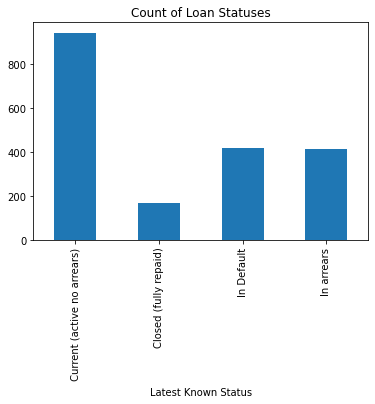

In [12]:
status_summary = loan.groupby(by=['Latest Known Status']).count()['Person_ID']
status_summary.plot.bar(title='Count of Loan Statuses')

In [13]:
check_missing(loan)

Latest Known Status has 648 missing values
Ever 90dpd+ has 648 missing values
Currently ≥ 60dpd has 648 missing values
Bad Indicator has 648 missing values


Some of feature columns have no values, so let's explore them.

In [14]:
loan[loan['Bad Indicator'].isna()]

,Person_ID,Loan_ID,Loan Tenure,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
1945,5909546,308Z700192700001,12,Monthly,102000,2019-09-27,2019-09-27,2019-09-27,2020-09-25,NaN,NaN,NaN,NaN
1946,8279482,609Z700192730001,12,Monthly,76000,2019-09-30,2019-09-30,2019-09-30,2020-09-30,NaN,NaN,NaN,NaN
1947,7359265,762Z700192700002,12,Monthly,53000,2019-09-27,2019-09-27,2019-09-27,2020-09-18,NaN,NaN,NaN,NaN
1948,6047107,805Z700192760001,12,Monthly,140000,2019-10-03,2019-10-03,2019-10-03,2020-09-25,NaN,NaN,NaN,NaN
1949,6295262,177Z700192770001,12,Monthly,149000,2019-10-04,2019-10-04,2019-10-04,2020-09-30,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,7366545,321Z700193540001,12,Monthly,350000,2019-12-20,2019-12-20,2019-12-20,2020-12-24,NaN,NaN,NaN,NaN
2589,8208065,557Z700193570001,12,Monthly,120000,2019-12-23,2019-12-23,2019-12-23,2020-12-30,NaN,NaN,NaN,NaN
2590,6243252,233Z700193580001,12,Monthly,99000,2019-12-24,2019-12-24,2019-12-24,2020-12-30,NaN,NaN,NaN,NaN
2591,5926348,500Z700193610001,9,Monthly,149000,2019-12-27,2019-12-27,2019-12-27,2020-09-30,NaN,NaN,NaN,NaN


As seen from the table above, there are 648 missing values each for the following columns:
* `Latest Known Status`
* `Ever 90dpd+`
* `Currently >= 60dpd`
* `Bad Indicator` (which is our dependent variable)

Also, looking at the `Loan Maturity Date` feature, it seems that the above columns are missing values because they represent future dates from the time the dataset was compiled.
Let's take a look at the loans for which payment is still currently being made.

<AxesSubplot:xlabel='Latest Known Status'>

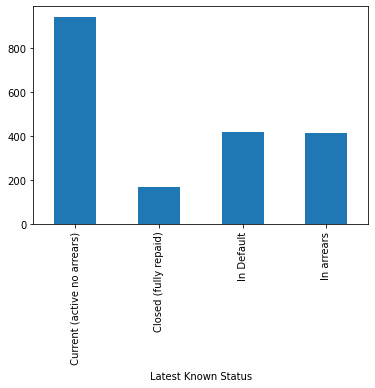

In [15]:
loan_by_status = loan[loan['Bad Indicator'].notna() == True ]\
    .groupby(by=['Latest Known Status'])\
    .count()['Bad Indicator']
loan_by_status.plot.bar()

<AxesSubplot:xlabel='Bad Indicator'>

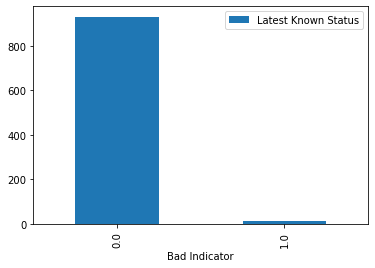

In [16]:
current_loans = loan[loan['Latest Known Status'] == ' Current (active no arrears)']
current_loans[['Latest Known Status', 'Bad Indicator']].groupby(by=['Bad Indicator']).count().plot.bar()

In [17]:
current_loans[current_loans['Bad Indicator'] == 1.0]

,Person_ID,Loan_ID,Loan Tenure,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
457,4357409,757Z700193010001,12,Monthly,149000,2019-10-28,2019-10-28,2019-10-28,2020-10-30,Current (active no arrears),1.0,0.0,1.0
483,5075641,168Z700193030001,12,Monthly,94000,2019-10-30,2019-10-30,2019-10-30,2020-10-30,Current (active no arrears),1.0,0.0,1.0
1201,8530985,332Z700193050001,12,Monthly,45000,2019-11-01,2019-11-01,2019-11-01,2020-10-28,Current (active no arrears),1.0,0.0,1.0
1211,5530314,012Z700193080001,12,Monthly,149000,2019-11-04,2019-11-04,2019-11-04,2020-10-30,Current (active no arrears),1.0,0.0,1.0
1340,6624241,347Z700193290001,12,Monthly,350000,2019-11-25,2019-11-25,2019-11-25,2020-11-30,Current (active no arrears),1.0,0.0,1.0
1371,8376730,139Z700193300002,12,Monthly,350000,2019-11-26,2019-11-26,2019-11-26,2020-11-30,Current (active no arrears),1.0,0.0,1.0
1387,8771617,424Z700193310001,12,Monthly,104000,2019-11-27,2019-11-27,2019-11-27,2020-11-30,Current (active no arrears),1.0,0.0,1.0
1417,2749624,014Z700193310002,12,Monthly,30000,2019-11-27,2019-11-27,2019-11-27,2020-12-04,Current (active no arrears),1.0,0.0,1.0
1481,6391193,829Z700193330001,12,Monthly,350000,2019-11-29,2019-11-29,2019-11-29,2020-11-27,Current (active no arrears),1.0,0.0,1.0
1485,6479018,037Z700193330501,12,Monthly,80000,2019-11-29,2019-11-29,2019-11-29,2020-11-27,Current (active no arrears),1.0,0.0,1.0


Here are
 active loans for which there are no arrears, but they are seen as bad loans. They are

In [18]:
fully_repaid_loans = loan[loan['Latest Known Status'] == 'Closed (fully repaid)']
fully_repaid_loans[fully_repaid_loans['Bad Indicator'] == 1.0]

,Person_ID,Loan_ID,Loan Tenure,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
1225,8736267,011Z700193110001,12,Monthly,350000,2019-11-07,2019-11-07,2019-11-07,2020-10-30,Closed (fully repaid),1.0,0.0,1.0
1383,5397972,568Z700193300002,12,Monthly,350000,2019-11-26,2019-11-26,2019-11-26,2020-11-30,Closed (fully repaid),1.0,0.0,1.0


In [19]:
num_gt_60dpd = loan[loan['Currently ≥ 60dpd'] == 1.0].count()['Loan_ID']
num_good_gt_60dpd = loan[(loan['Currently ≥ 60dpd'] == 1.0) & (loan['Bad Indicator'] != 1.0)].count()['Loan_ID']
num_bad_gt_60dpd = loan[(loan['Currently ≥ 60dpd'] == 1.0) & (loan['Bad Indicator'] == 1.0)].count()['Loan_ID']
print(f'There are {num_gt_60dpd} loans that are 60 days past due, '
      f'{num_good_gt_60dpd} are good and {num_bad_gt_60dpd} are bad')

There are 582 loans that are 60 days past due, 0 are good and 582 are bad


Loans that are 60 days past due date are either In Default or In arrears, and they are all bad loans. There are 582 of them.

In [20]:
num_gt_60dpd = loan[loan['Currently ≥ 60dpd'] == 1.0].count()['Loan_ID']
num_good_gt_60dpd = loan[(loan['Currently ≥ 60dpd'] == 1.0) & (loan['Bad Indicator'] != 1.0)].count()['Loan_ID']
num_bad_gt_60dpd = loan[(loan['Currently ≥ 60dpd'] == 1.0) & (loan['Bad Indicator'] == 1.0)].count()['Loan_ID']
print(f'There are {num_gt_60dpd} loans that are 60 days past due, '
      f'{num_good_gt_60dpd} are good and {num_bad_gt_60dpd} are bad')

There are 582 loans that are 60 days past due, 0 are good and 582 are bad


In [21]:
default_loans = loan[loan['Latest Known Status'] == 'In Default']['Loan_ID']\
    .count()
default_bad_indicators = loan[(loan['Latest Known Status'] == 'In Default')
                              & (loan['Bad Indicator'] == 1.0)]['Loan_ID']\
    .count()
default_good_indicators = loan[(loan['Latest Known Status'] == 'In Default')
                               & (loan['Bad Indicator'] != 1.0)]['Loan_ID']\
    .count()

print(f'There are {default_loans} default loans, {default_bad_indicators} are bad loans and {default_good_indicators} are good loans.')

There are 418 default loans, 418 are bad loans and 0 are good loans.


From the data, all default loans are bad loans.

There are four values for `Latest Known Statuses`

Most loans are due for repayment within a year.

In [22]:
loan_corr = loan.corr()
loan_corr.style.background_gradient(cmap='coolwarm')

,Person_ID,Loan Tenure,Loan Amount (Principal),Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
Person_ID,1.000000,-0.026429,0.057976,0.133064,0.154347,0.156628
Loan Tenure,-0.026429,1.000000,0.056775,0.010328,0.002743,0.009164
Loan Amount (Principal),0.057976,0.056775,1.000000,0.032674,0.064356,0.068282
Ever 90dpd+,0.133064,0.010328,0.032674,1.000000,0.780405,0.810739
Currently ≥ 60dpd,0.154347,0.002743,0.064356,0.780405,1.000000,0.978361
Bad Indicator,0.156628,0.009164,0.068282,0.810739,0.978361,1.000000


There's a high correlation between `Currently >= 60dpd` and `Bad Indicator`. There is also a high correlation between `Ever 90dpd+` and `Bad Indicator`. This means that a major indicator of bad loans is

## Transactions

In [23]:
transaction.dtypes

TRN_DT             datetime64[ns]
Person_ID                   int64
TRANS_TYPE                 object
AMOUNT_IN_NAIRA           float64
NARRATION                  object
dtype: object

In [24]:
transaction.sample(10)

,TRN_DT,Person_ID,TRANS_TYPE,AMOUNT_IN_NAIRA,NARRATION
117400,2019-11-26,4716968,Debit,78.0,SELF-EMPLOYED TRADING AMORTISED-030Z700193300002
139180,2019-06-03,5115155,Credit,15000.0,Mobile Transfer from xxxxxxxxx
74905,2019-06-21,3926802,Debit,10000.0,AWR@10321811/3 Nwoba Lane AWKA ONITSHA ...
584612,2019-08-26,8705041,Debit,1000.0,BANKMobile/QT PYMT/Airtime Recharge on +0#####...
514935,2019-11-05,8437248,Debit,1490.0,MANAGEMENT FEE
237103,2019-10-14,6011266,Credit,3000.0,UIP Trf from xxxxxxxxxxxxxxxxxxxxxx
259784,2019-10-17,6257600,Credit,20000.0,"PYA@3QTL002/CPT,T,119799993538857,Patience, Ek..."
583930,2019-10-22,8698236,Debit,5000.0,AWR@10350411/AKARIGBO ST AJEGUNLE SAGAMU ...
86276,2019-06-21,4139442,Debit,200.0,USSD/QT PYMT/Airtime Recharge on 0##########
86379,2019-09-11,4139442,Debit,20000.0,AWR@17016496/Aba Abayi ATM6 Aba ...


In [25]:
transaction.describe()

,Person_ID,AMOUNT_IN_NAIRA
count,6.087250e+05,6.087250e+05
mean,6.357631e+06,2.738425e+04
std,2.001543e+06,1.226310e+05
min,8.280100e+04,-5.000000e+05
25%,5.303229e+06,1.000000e+03
50%,6.695806e+06,6.000000e+03
75%,8.012117e+06,2.000000e+04
max,8.977774e+06,3.040000e+07


In [26]:
transaction['TRN_DT'].min()

Timestamp('2019-03-29 00:00:00')

Now, let's get the bank balance of each person represented by Person_ID.

In [27]:
balances: pd.DataFrame = transaction.groupby(by=['Person_ID', 'TRANS_TYPE'])\
    .sum()['AMOUNT_IN_NAIRA'].unstack()
balances["balance"] = balances["Credit"] - balances["Debit"]
balances

TRANS_TYPE,Credit,Debit,balance
Person_ID,,,
82801,1093369.33,974108.45,119260.88
206079,346598.51,428406.12,-81807.61
256568,879590.00,847142.50,32447.50
273959,1885102.07,1563897.00,321205.07
274608,9306402.50,9290080.00,16322.50
...,...,...,...
8919015,568350.73,446944.38,121406.35
8922911,1208767.76,1055315.41,153452.35
8959337,8985852.50,9125645.02,-139792.52


In [28]:
balances.unstack()

TRANS_TYPE  Person_ID
Credit      82801        1093369.33
            206079        346598.51
            256568        879590.00
            273959       1885102.07
            274608       9306402.50
                            ...    
balance     8919015       121406.35
            8922911       153452.35
            8959337      -139792.52
            8976531        18778.38
            8977774       322137.50
Length: 7779, dtype: float64

Number of loans the person has taken before.
When last they took a loan.

# Feature Engineering

Data merge

In [29]:
data = person.merge(balances, on='Person_ID', how='inner')
data = data.merge(loan, on='Person_ID', how='inner')

In [30]:
check_missing(data)
data[(data['OCCUPATION'].isna()) | (data['BUSINESS_TYPE'].isna())]

OCCUPATION has 818 missing values
BUSINESS_TYPE has 1278 missing values
Latest Known Status has 648 missing values
Ever 90dpd+ has 648 missing values
Currently ≥ 60dpd has 648 missing values
Bad Indicator has 648 missing values


,Person_ID,Loan Account Number,Relationship_Start_Date,OCCUPATION,DATE_OF_BIRTH,BUSINESS_TYPE,STATE,No_of_Mobile_No,CUSTOMER_EMAIL,GENDER,...,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
0,8671296,346Z700193290001,2019-02-12,NaN,1970-12-31,NaN,Kwara,1,N,M,...,Monthly,316000,2019-11-25,2019-11-25,2019-11-25,2020-12-04,In Default,1.0,1.0,1.0
1,4650228,347Z700193320501,2009-09-28,NaN,1969-02-05,BUSINESS,PLATEAU,1,N,M,...,Monthly,350000,2019-11-28,2019-11-28,2019-11-28,2020-11-30,Current (active no arrears),0.0,0.0,0.0
2,8368795,065Z700193300001,2018-11-16,OTHERS,1970-11-14,NaN,ONDO,1,N,M,...,Monthly,90000,2019-11-26,2019-11-26,2019-11-26,2020-11-26,In arrears,0.0,0.0,0.0
4,7282857,585Z700193330001,2017-12-29,NaN,1977-11-11,NaN,Kogi,1,N,F,...,Monthly,145000,2019-11-29,2019-11-29,2019-11-29,2020-11-20,In arrears,0.0,0.0,0.0
5,8520403,252Z700192960001,2018-12-31,NaN,1976-11-16,NaN,Oyo,1,Y,M,...,Monthly,222000,2019-10-23,2019-10-23,2019-10-23,2020-10-30,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,8287758,229Z700193330001,2018-10-26,OTHERS,1982-11-29,NaN,OYO,1,N,F,...,Monthly,149000,2019-11-29,2019-11-29,2019-11-29,2020-11-27,Current (active no arrears),0.0,0.0,0.0
2584,8455526,025Z700193030001,2018-12-11,OTHERS,1985-06-24,NaN,ABIA,1,N,M,...,Monthly,149000,2019-10-30,2019-10-30,2019-10-30,2020-10-30,In arrears,0.0,1.0,1.0
2585,8695289,257Z700193160001,2019-02-19,NaN,1965-06-16,NaN,Kogi,1,Y,F,...,Monthly,141000,2019-11-12,2019-11-12,2019-11-12,2020-10-30,Current (active no arrears),0.0,0.0,0.0
2587,5444353,565Z700193250001,2013-06-20,NaN,1973-06-15,SELF EMPLOYED,KWARA,1,N,M,...,Monthly,106000,2019-11-21,2019-11-21,2019-11-21,2020-11-30,NaN,NaN,NaN,NaN


In [31]:
data

,Person_ID,Loan Account Number,Relationship_Start_Date,OCCUPATION,DATE_OF_BIRTH,BUSINESS_TYPE,STATE,No_of_Mobile_No,CUSTOMER_EMAIL,GENDER,...,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
0,8671296,346Z700193290001,2019-02-12,NaN,1970-12-31,NaN,Kwara,1,N,M,...,Monthly,316000,2019-11-25,2019-11-25,2019-11-25,2020-12-04,In Default,1.0,1.0,1.0
1,4650228,347Z700193320501,2009-09-28,NaN,1969-02-05,BUSINESS,PLATEAU,1,N,M,...,Monthly,350000,2019-11-28,2019-11-28,2019-11-28,2020-11-30,Current (active no arrears),0.0,0.0,0.0
2,8368795,065Z700193300001,2018-11-16,OTHERS,1970-11-14,NaN,ONDO,1,N,M,...,Monthly,90000,2019-11-26,2019-11-26,2019-11-26,2020-11-26,In arrears,0.0,0.0,0.0
3,7069330,632Z700193260001,2017-10-06,FARMING,1962-02-15,1,Plateau,2,N,M,...,Monthly,52000,2019-11-22,2019-11-22,2019-11-22,2020-11-30,NaN,NaN,NaN,NaN
4,7282857,585Z700193330001,2017-12-29,NaN,1977-11-11,NaN,Kogi,1,N,F,...,Monthly,145000,2019-11-29,2019-11-29,2019-11-29,2020-11-20,In arrears,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,8421669,408Z700193380001,2018-11-30,CIVIL SERVANT,1981-12-15,1,Lagos,1,Y,M,...,Monthly,80000,2019-12-04,2019-12-04,2019-12-04,2020-11-30,Current (active no arrears),0.0,0.0,0.0
2589,7579196,235Z700193310001,2018-04-10,Artisan,1982-03-24,1,Oyo,2,Y,M,...,Monthly,200000,2019-11-27,2019-11-27,2019-11-27,2020-05-25,Current (active no arrears),0.0,0.0,0.0
2590,6518178,282Z700193260001,2016-12-14,1,1989-12-24,1,Edo,1,Y,M,...,Monthly,149000,2019-11-22,2019-11-22,2019-11-22,2020-11-20,Current (active no arrears),0.0,0.0,0.0
2591,8407071,182Z700193330001,2018-11-26,NaN,1979-10-28,NaN,Enugu,1,N,M,...,Monthly,149000,2019-11-29,2019-11-29,2019-11-29,2020-11-30,In arrears,0.0,1.0,1.0


### Handle Missing Values

In [32]:
check_missing(data)

OCCUPATION has 818 missing values
BUSINESS_TYPE has 1278 missing values
Latest Known Status has 648 missing values
Ever 90dpd+ has 648 missing values
Currently ≥ 60dpd has 648 missing values
Bad Indicator has 648 missing values


In [33]:
data[data['Ever 90dpd+'].isna()]

,Person_ID,Loan Account Number,Relationship_Start_Date,OCCUPATION,DATE_OF_BIRTH,BUSINESS_TYPE,STATE,No_of_Mobile_No,CUSTOMER_EMAIL,GENDER,...,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
3,7069330,632Z700193260001,2017-10-06,FARMING,1962-02-15,1,Plateau,2,N,M,...,Monthly,52000,2019-11-22,2019-11-22,2019-11-22,2020-11-30,NaN,NaN,NaN,NaN
5,8520403,252Z700192960001,2018-12-31,NaN,1976-11-16,NaN,Oyo,1,Y,M,...,Monthly,222000,2019-10-23,2019-10-23,2019-10-23,2020-10-30,NaN,NaN,NaN,NaN
6,7972561,256Z700193400001,2018-08-08,Artisan,1986-07-07,Artisan,Plateau,1,N,F,...,Monthly,297000,2019-12-06,2019-12-06,2019-12-06,2020-11-30,NaN,NaN,NaN,NaN
12,6348961,757Z700193220002,2016-07-21,NaN,1976-11-06,NaN,Kwara,1,N,M,...,Monthly,149000,2019-11-18,2019-11-18,2019-11-18,2020-11-30,NaN,NaN,NaN,NaN
14,8223447,611Z700193360002,2018-10-11,1,1978-03-14,1,Ogun,1,N,M,...,Monthly,350000,2019-12-02,2019-12-02,2019-12-02,2020-11-30,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576,3222549,612Z700193380501,2002-08-06,NaN,1978-11-04,NaN,DELTA,1,N,M,...,Monthly,82000,2019-12-04,2019-12-04,2019-12-04,2020-11-27,NaN,NaN,NaN,NaN
2577,3819473,014Z700193310001,2006-11-16,Domestic trade retail,1976-03-15,SALES REPRESENTATIVE,ANAMBRA,1,N,M,...,Monthly,310000,2019-11-27,2019-11-27,2019-11-27,2020-11-25,NaN,NaN,NaN,NaN
2579,8190606,567Z700193460001,2018-10-03,1,1986-08-26,1,Ogun,1,N,M,...,Monthly,332000,2019-12-12,2019-12-12,2019-12-12,2020-11-27,NaN,NaN,NaN,NaN
2582,6191104,597Z700192980001,2016-02-04,Artisan,1991-11-15,Artisan,Anambra,2,N,M,...,Monthly,140000,2019-10-25,2019-10-25,2019-10-25,2020-10-30,NaN,NaN,NaN,NaN


In [34]:
data.sort_values('Loan Maturity Date', ascending=True)

,Person_ID,Loan Account Number,Relationship_Start_Date,OCCUPATION,DATE_OF_BIRTH,BUSINESS_TYPE,STATE,No_of_Mobile_No,CUSTOMER_EMAIL,GENDER,...,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
581,6481111,576Z700193050502,2016-11-17,NaN,1992-01-11,NaN,Delta,1,N,F,...,Monthly,76000,2019-11-01,2019-11-01,2019-11-01,2019-12-30,Closed (fully repaid),0.0,0.0,0.0
1517,8440194,805Z700193170001,2018-12-06,Artisan,1987-09-26,Artisan,Oyo,1,N,F,...,Monthly,149000,2019-11-13,2019-11-13,2019-11-13,2020-01-08,NaN,NaN,NaN,NaN
1381,8376119,235Z700193240001,2018-11-19,NaN,1987-01-26,NaN,Oyo,1,N,M,...,Monthly,100000,2019-11-20,2019-11-20,2019-11-20,2020-01-20,NaN,NaN,NaN,NaN
279,8379116,235Z700193010001,2018-11-19,1,1970-11-01,1,Oyo,1,N,F,...,Monthly,350000,2019-10-28,2019-10-28,2019-10-28,2020-01-23,Current (active no arrears),0.0,0.0,0.0
2437,6693433,659Z700193030001,2017-03-07,Artisan,1997-05-26,Artisan,Ogun,1,N,M,...,Monthly,20000,2019-10-30,2019-10-30,2019-10-30,2020-01-28,Closed (fully repaid),0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,7701125,612Z700192950001,2018-05-16,BUSINESS,1972-06-07,1,Delta,1,N,F,...,Monthly,149000,2019-10-22,2019-10-22,2019-10-22,2021-04-16,In Default,1.0,1.0,1.0
325,6406235,154Z705193330001,2016-09-19,Artisan,1986-05-13,1,Kogi,1,Y,M,...,Monthly,1000000,2019-11-29,2019-11-29,2019-11-29,2021-05-28,Closed (fully repaid),0.0,0.0,0.0
405,7149113,495Z705193390001,2017-11-08,1,1966-09-01,1,Kogi,1,Y,M,...,Monthly,1000000,2019-12-05,2019-12-05,2019-12-05,2021-05-28,In Default,1.0,1.0,1.0
2462,8083708,595Z700193010001,2018-09-05,Business,1997-09-29,Business,Anambra,1,N,F,...,Monthly,350000,2019-10-28,2019-10-28,2019-10-28,2021-10-21,Current (active no arrears),0.0,0.0,0.0


In [35]:
earliest_nan_loan_approval_date = data[data['Ever 90dpd+'].isna()]['Loan Approval Date'].min()
latest_nan_loan_approval_date = data[data['Ever 90dpd+'].isna()]['Loan Approval Date'].max()
print(f'The earliest date for loan approval for missing values is {earliest_nan_loan_approval_date}')
print(f'The latest date for loan approval for missing values is {latest_nan_loan_approval_date}')

The earliest date for loan approval for missing values is 2019-09-27 00:00:00
The latest date for loan approval for missing values is 2019-12-31 00:00:00


The following features are NaN probably because the future date:
* Currently >= 60dpd
* Ever 90dpd+
* Bad Indicator
* Latest Known Status

We will fill them with 0 and ' Current (active no arrears)'

In [36]:
for col in ['Currently ≥ 60dpd', 'Ever 90dpd+', 'Bad Indicator']:
    data[col].fillna(0., inplace=True)
data['Latest Known Status'].fillna(' Current (active no arrears)', inplace=True)
data

,Person_ID,Loan Account Number,Relationship_Start_Date,OCCUPATION,DATE_OF_BIRTH,BUSINESS_TYPE,STATE,No_of_Mobile_No,CUSTOMER_EMAIL,GENDER,...,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
0,8671296,346Z700193290001,2019-02-12,NaN,1970-12-31,NaN,Kwara,1,N,M,...,Monthly,316000,2019-11-25,2019-11-25,2019-11-25,2020-12-04,In Default,1.0,1.0,1.0
1,4650228,347Z700193320501,2009-09-28,NaN,1969-02-05,BUSINESS,PLATEAU,1,N,M,...,Monthly,350000,2019-11-28,2019-11-28,2019-11-28,2020-11-30,Current (active no arrears),0.0,0.0,0.0
2,8368795,065Z700193300001,2018-11-16,OTHERS,1970-11-14,NaN,ONDO,1,N,M,...,Monthly,90000,2019-11-26,2019-11-26,2019-11-26,2020-11-26,In arrears,0.0,0.0,0.0
3,7069330,632Z700193260001,2017-10-06,FARMING,1962-02-15,1,Plateau,2,N,M,...,Monthly,52000,2019-11-22,2019-11-22,2019-11-22,2020-11-30,Current (active no arrears),0.0,0.0,0.0
4,7282857,585Z700193330001,2017-12-29,NaN,1977-11-11,NaN,Kogi,1,N,F,...,Monthly,145000,2019-11-29,2019-11-29,2019-11-29,2020-11-20,In arrears,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,8421669,408Z700193380001,2018-11-30,CIVIL SERVANT,1981-12-15,1,Lagos,1,Y,M,...,Monthly,80000,2019-12-04,2019-12-04,2019-12-04,2020-11-30,Current (active no arrears),0.0,0.0,0.0
2589,7579196,235Z700193310001,2018-04-10,Artisan,1982-03-24,1,Oyo,2,Y,M,...,Monthly,200000,2019-11-27,2019-11-27,2019-11-27,2020-05-25,Current (active no arrears),0.0,0.0,0.0
2590,6518178,282Z700193260001,2016-12-14,1,1989-12-24,1,Edo,1,Y,M,...,Monthly,149000,2019-11-22,2019-11-22,2019-11-22,2020-11-20,Current (active no arrears),0.0,0.0,0.0
2591,8407071,182Z700193330001,2018-11-26,NaN,1979-10-28,NaN,Enugu,1,N,M,...,Monthly,149000,2019-11-29,2019-11-29,2019-11-29,2020-11-30,In arrears,0.0,1.0,1.0


In [37]:
check_missing(data)

OCCUPATION has 818 missing values
BUSINESS_TYPE has 1278 missing values


We still have OCCUPATION and BUSINESS_TYPE left to handle.
* We will use OTHERS for NaN in OCCUPATION and where values are 1
* We will use OTHERS for NaN in BUSINESS_TYPE and where values are 1

In [38]:
data['OCCUPATION'].fillna('OTHERS', inplace=True)
data['OCCUPATION'].replace('1', 'OTHERS', inplace=True)

data['BUSINESS_TYPE'].fillna('OTHERS', inplace=True)
data['BUSINESS_TYPE'].replace('1', 'OTHERS', inplace=True)

data

,Person_ID,Loan Account Number,Relationship_Start_Date,OCCUPATION,DATE_OF_BIRTH,BUSINESS_TYPE,STATE,No_of_Mobile_No,CUSTOMER_EMAIL,GENDER,...,Payment Period,Loan Amount (Principal),Loan Application Date,Loan Approval Date,Loan Disbursement Date,Loan Maturity Date,Latest Known Status,Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
0,8671296,346Z700193290001,2019-02-12,OTHERS,1970-12-31,OTHERS,Kwara,1,N,M,...,Monthly,316000,2019-11-25,2019-11-25,2019-11-25,2020-12-04,In Default,1.0,1.0,1.0
1,4650228,347Z700193320501,2009-09-28,OTHERS,1969-02-05,BUSINESS,PLATEAU,1,N,M,...,Monthly,350000,2019-11-28,2019-11-28,2019-11-28,2020-11-30,Current (active no arrears),0.0,0.0,0.0
2,8368795,065Z700193300001,2018-11-16,OTHERS,1970-11-14,OTHERS,ONDO,1,N,M,...,Monthly,90000,2019-11-26,2019-11-26,2019-11-26,2020-11-26,In arrears,0.0,0.0,0.0
3,7069330,632Z700193260001,2017-10-06,FARMING,1962-02-15,OTHERS,Plateau,2,N,M,...,Monthly,52000,2019-11-22,2019-11-22,2019-11-22,2020-11-30,Current (active no arrears),0.0,0.0,0.0
4,7282857,585Z700193330001,2017-12-29,OTHERS,1977-11-11,OTHERS,Kogi,1,N,F,...,Monthly,145000,2019-11-29,2019-11-29,2019-11-29,2020-11-20,In arrears,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,8421669,408Z700193380001,2018-11-30,CIVIL SERVANT,1981-12-15,OTHERS,Lagos,1,Y,M,...,Monthly,80000,2019-12-04,2019-12-04,2019-12-04,2020-11-30,Current (active no arrears),0.0,0.0,0.0
2589,7579196,235Z700193310001,2018-04-10,Artisan,1982-03-24,OTHERS,Oyo,2,Y,M,...,Monthly,200000,2019-11-27,2019-11-27,2019-11-27,2020-05-25,Current (active no arrears),0.0,0.0,0.0
2590,6518178,282Z700193260001,2016-12-14,OTHERS,1989-12-24,OTHERS,Edo,1,Y,M,...,Monthly,149000,2019-11-22,2019-11-22,2019-11-22,2020-11-20,Current (active no arrears),0.0,0.0,0.0
2591,8407071,182Z700193330001,2018-11-26,OTHERS,1979-10-28,OTHERS,Enugu,1,N,M,...,Monthly,149000,2019-11-29,2019-11-29,2019-11-29,2020-11-30,In arrears,0.0,1.0,1.0


In [39]:
check_missing(data)
# Now we have no missing values.

### Drop Columns
Based on domain knowledge, some columns do not contribute to the dependent variable

In [40]:
drop_columns = ['Person_ID', 'Loan Account Number', 'Relationship_Start_Date', 'DATE_OF_BIRTH',
                'CUSTOMER_EMAIL', 'Loan_ID', 'Payment Period', 'Loan Application Date',
                'Loan Approval Date', 'Loan Disbursement Date', 'Loan Maturity Date',
                'Relationship_Start_Date']
data = data.drop(labels=drop_columns, axis='columns')

### Make columns categorical

In [41]:
categorical = ['OCCUPATION', 'BUSINESS_TYPE', 'STATE', 'GENDER', 'MARITAL_STATUS', 'REGION', 'BASIC_CURRENT', 'BASIC_SAVINGS', 'ATMCARD']
for col in categorical:
    data[col] = data[col].astype('category')

In [42]:
data_corr = data.corr()
data_corr.style.background_gradient(cmap='coolwarm')

,No_of_Mobile_No,TOTAL_PRODUCTS,Credit,Debit,balance,Loan Tenure,Loan Amount (Principal),Ever 90dpd+,Currently ≥ 60dpd,Bad Indicator
No_of_Mobile_No,1.000000,0.034357,0.054151,0.051821,0.042669,-0.007365,0.040127,0.033872,0.027636,0.026443
TOTAL_PRODUCTS,0.034357,1.000000,0.108964,0.108280,0.023239,-0.029814,0.105130,-0.099284,-0.101268,-0.104753
Credit,0.054151,0.108964,1.000000,0.997996,0.146410,-0.044426,0.381092,-0.042550,-0.046077,-0.045442
Debit,0.051821,0.108280,0.997996,1.000000,0.083528,-0.048595,0.366657,-0.041003,-0.043890,-0.043515
balance,0.042669,0.023239,0.146410,0.083528,1.000000,0.060075,0.269547,-0.029091,-0.039495,-0.035367
Loan Tenure,-0.007365,-0.029814,-0.044426,-0.048595,0.060075,1.000000,0.056775,0.004659,-0.002584,0.002667
Loan Amount (Principal),0.040127,0.105130,0.381092,0.366657,0.269547,0.056775,1.000000,0.022101,0.047071,0.050092
Ever 90dpd+,0.033872,-0.099284,-0.042550,-0.041003,-0.029091,0.004659,0.022101,1.000000,0.797192,0.825042
Currently ≥ 60dpd,0.027636,-0.101268,-0.046077,-0.043890,-0.039495,-0.002584,0.047071,0.797192,1.000000,0.980468
Bad Indicator,0.026443,-0.104753,-0.045442,-0.043515,-0.035367,0.002667,0.050092,0.825042,0.980468,1.000000


## Export to CSV

In [43]:
data.to_csv('full-loan-data.csv', index=False)